In [1]:
# Leer ficheros de datos
import codecs
import pandas as pd
import pyarrow.parquet as pq
# Extraer información
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
# Auxiliares
import numpy as np
import logging
from typing import Union
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Carga de datos

In [2]:
df = pd.read_parquet('Datasets/PHA/PHA_Data.parquet', engine='pyarrow')


### Convertimos cualquier tipo de registro faltante a NaN

In [3]:
def clean_data(value): 
    # Si se trata de un valor en blanco sustituir a NaN 
    try: 
        if value in [None, 'nan']: 
            return np.nan 
         
        return value 
 
    except Exception as e: 
        return value 
     
# Iterar sobre todas las columnas y comprobar sus valores 
columns = len(df.columns) 
 
for column in df.columns: 
    # Utilizar compresion de listas y aplicar el filtrado de valores 
    values = [clean_data(value) for value in df[column]] 
    df[column] = values 
    columns -= 1 
    print(f'[+] REMAINING_COLUMNS\t{columns}\t', end='\r') 
     
df

,c1,c6,c7,c8,c10,c132,c134,c136,c138,c141,...,c150,c154,c156,c158,c161,c163,c183,c191,c229,c230
0,A,1975,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,POWERED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,1975,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,POWERED,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,NaN,NaN
2,A,1975,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,POWERED,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,NaN,NaN
3,A,1975,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,POWERED,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,NaN,NaN
4,A,1975,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,POWERED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214882,I,2022,2,6,0930,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,19470720.0,NaN
214883,I,2022,2,6,1710,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,19700731.0,NaN
214884,I,2022,1,31,0832,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,19810601.0,19980409.0
214885,I,2022,1,7,0407,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Wheeled-Tricycle,NaN,NaN,NaN,NaN,19520606.0,NaN


### Cargamos cabecera  y convertimos a dataframe

In [4]:
url_legend = 'https://av-info.faa.gov/data/AID/Afilelayout.txt'
# Leemos el contenido de la leyenda
with urlopen(url_legend) as content:
    soup = BeautifulSoup(content, "html.parser")
    soup_lines = str(soup).split('\r\n')

# Transformamos la respuesta en un diccionario con el nombre de la columna y la descripción
legend_df = {"Column_name": [], "Description": []}
# Recorrer las lineas con datos de lineas. Se salta las dos primeras y las tres ultimas
# filas por no tener datos relevantes de la leyenda
for line in soup_lines[2:-3]:
    # Se extrae los 5 primeros caracteres para conocer el nombre de la columna
    legend_df["Column_name"].append(line[0:5].strip())
    # Se extrae la descripcion, esta comienza en la posicion 53
    legend_df["Description"].append(line[53:].strip())
    
# Convertir el diccionario en pandas.Dataframe
legend_df = pd.DataFrame.from_dict(data=legend_df)
legend_df

,Column_name,Description
0,c5,Unique control number used to relate to AID_MA...
1,c1,Type of Event
2,c2,FAR part number
3,c3,Form on which the latest data was received.
4,c4,Agency conducting investigation.
...,...,...
174,c163,2nd Additional cause factor text
175,c183,Supporting Factor Text ...
176,c191,Supporting cause factor B text. O...
177,c229,Date of Birth of PIC


### Enumeramos las cabecera con la descripción para poder verlas mejor y seleccionamos las columnas que podrían ser relevantes

In [5]:
used_columns = ['c76','c1', 'c6', 'c7', 'c8', 'c10', 'c23', 'c24', 'c11', 'c110', 'c114', 'c115', 'c117', 'c118', 'c61', 'c62', 'c65', 'c68', 'c41', 'c45', 'c49', 'c50', 'c52', 'c53', 'c54', 'c55', 'c56', 'c120', 'c121', 'c122', 'c126', 'c127', 'c128', 'c130', 'c84', 'c86', 'c88', 'c90', 'c92', 'c96','c48', 'c51', 'c229', 'c230']
#used_columns = [f'c{idx}' for idx in used_columns]

for col in used_columns:
    description = legend_df[legend_df["Column_name"] == col]["Description"].values[0]
    print(f'[+]  Descripción columnas\t{col}\t{description}')
   

[+]  Descripción columnas	c76	Total Fatalities
[+]  Descripción columnas	c1	Type of Event
[+]  Descripción columnas	c6	Year the accident/incident happened.
[+]  Descripción columnas	c7	Month the accident/incident happened.
[+]  Descripción columnas	c8	Day the accident/incident happened.
[+]  Descripción columnas	c10	Local time of the accident/incident.
[+]  Descripción columnas	c23	Make of the aircraft
[+]  Descripción columnas	c24	Model of the aircraft
[+]  Descripción columnas	c11	Region of the accident/incident location.
[+]  Descripción columnas	c110	Light condition code
[+]  Descripción columnas	c114	Visibility code
[+]  Descripción columnas	c115	Visibility restriction code.
[+]  Descripción columnas	c117	Runway condition code
[+]  Descripción columnas	c118	Braking condition code
[+]  Descripción columnas	c61	Including crew and passengers.
[+]  Descripción columnas	c62	Number of passengers onboard
[+]  Descripción columnas	c65	Number of flight crew members onboard
[+]  Descripción

### Creamos dataframe a partir del primario usando solamente las columnas de la lista anteriormente  generada

In [6]:
data= df.loc[:, used_columns]

In [7]:
data.shape

(214887, 44)

### Realizamos un conteo de los datos faltantes NaN de las columnas que pueden ser potenciales

In [8]:
# Contar el número de valores NaN en cada columna
print(data.isna().sum())

c76         33
c1           8
c6           0
c7          33
c8          33
c10      21286
c23       1967
c24       1839
c11        508
c110     46444
c114    126665
c115    196711
c117    134290
c118    196677
c61         33
c62       5967
c65       5967
c68       5967
c41      13801
c45      57794
c49      58745
c50      48583
c52      49902
c53      36021
c54      91362
c55      40299
c56      37095
c120    136518
c121    175966
c122    175468
c126    173817
c127    173290
c128    173297
c130     64166
c84     178376
c86     153197
c88     163547
c90     163570
c92     208598
c96       7062
c48      58745
c51      49902
c229    202962
c230    213480
dtype: int64


### Procedemos a borrar las columnas con demasiados datos faltantes (más de 100.000 unidades) y las filas que tengan más de 3 valores faltantes

In [9]:
#Borramos columnas que tengan más de 100.000 datos faltantes  
data = data.dropna(thresh=100000, axis=1)
data = data.dropna(thresh=3)

### Volvemos a contar despues del borrado para ver que columnas son aprovechables

In [10]:
# Contar el número de valores NaN en cada columna
print(data.isna().sum())



c76         1
c1          0
c6          0
c7          1
c8          1
c10     21254
c23      1935
c24      1807
c11       476
c110    46412
c61         1
c62      5935
c65      5935
c68      5935
c41     13769
c45     57762
c49     58713
c50     48551
c52     49870
c53     35989
c54     91330
c55     40267
c56     37063
c130    64134
c96      7030
c48     58713
c51     49870
dtype: int64


In [11]:
columnas = list(data.columns)
for col in columnas:
    description = legend_df[legend_df["Column_name"] == col]["Description"].values[0]
    print(f'[+] Descripción columnas\t{col}\t{description}')

[+] Descripción columnas	c76	Total Fatalities
[+] Descripción columnas	c1	Type of Event
[+] Descripción columnas	c6	Year the accident/incident happened.
[+] Descripción columnas	c7	Month the accident/incident happened.
[+] Descripción columnas	c8	Day the accident/incident happened.
[+] Descripción columnas	c10	Local time of the accident/incident.
[+] Descripción columnas	c23	Make of the aircraft
[+] Descripción columnas	c24	Model of the aircraft
[+] Descripción columnas	c11	Region of the accident/incident location.
[+] Descripción columnas	c110	Light condition code
[+] Descripción columnas	c61	Including crew and passengers.
[+] Descripción columnas	c62	Number of passengers onboard
[+] Descripción columnas	c65	Number of flight crew members onboard
[+] Descripción columnas	c68	Number of cabin crew members onboard
[+] Descripción columnas	c41	Certificate type code of the pilot in command
[+] Descripción columnas	c45	Rating code of the pilot in command
[+] Descripción columnas	c49	Qualific

In [12]:
data.shape

(214855, 27)

## ESTUDIO DE COLUMNAS PARA SABER CUALES SON CATEGORICAS Y CUALES NUMERICAS PARA PROCEDER SEGUIDAMENTE A LA IMPUTACIÓN

Si se optara por hacerlo de forma automatica hay atributos que se clasificaran como categoricos cuando no lo son y viceversa
Por lo que hay que proceder a hacerlo manualmente mediante dos pasos:
En el primer paso se comprueba la cantidad de valores unicos clasificando los que superan los 100 valores como numericos. 
En segundo lugar hay que comprobar que los valores no unicos no contengan string


### Primer paso

In [13]:
# Podemos apreciar la cantidad de valores unicos de cada columna
# vamos a establecer que los que tengan más de 100 valores unicos son numericos y los restantes categoricos

for col in data.columns:
    print(col, data[col].nunique())

c76 54
c1 3
c6 49
c7 12
c8 31
c10 1489
c23 3739
c24 9352
c11 19
c110 5
c61 431
c62 412
c65 13
c68 30
c41 15
c45 55
c49 14
c50 85
c52 16
c53 4931
c54 476
c55 595
c56 13172
c130 10
c96 76
c48 14
c51 16


In [14]:
#Vamos a establecer como criterio de clasificación las que superen 100 caracteres unicos serán numericas
#las restantes serán categoricas

# Definimos una lista para almacenar las columnas numéricas
num_cols = []

# Definimos una lista para almacenar las columnas categóricas
cat_cols = []

# Verificamos la cardinalidad de cada columna
for col in data.columns:
    unique_vals = data[col].nunique()
    if unique_vals >= 100:
        num_cols.append(col)
    else:
        cat_cols.append(col)

# Imprimimos las columnas numéricas y categóricas
print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

Columnas numéricas: ['c10', 'c23', 'c24', 'c61', 'c62', 'c53', 'c54', 'c55', 'c56']
Columnas categóricas: ['c76', 'c1', 'c6', 'c7', 'c8', 'c11', 'c110', 'c65', 'c68', 'c41', 'c45', 'c49', 'c50', 'c52', 'c130', 'c96', 'c48', 'c51']


### Segundo paso

Segundo criterio consiste en ver el tipo de datos de los atributos clasificados en el primer paso, si son numericos pueden ser categoricos o numericos pero si son tipo string tienen que ser categoricos 

In [15]:
for col in num_cols:
    try:
        numeric_values = pd.to_numeric(data[col])
        non_numeric_values = numeric_values.isna().sum()
        print(f"La columna '{col}' tiene {non_numeric_values} valores no numéricos (excluyendo NaN)")
    except ValueError:
        print(f"La columna '{col}' contiene valores no numéricos")

La columna 'c10' contiene valores no numéricos
La columna 'c23' contiene valores no numéricos
La columna 'c24' contiene valores no numéricos
La columna 'c61' tiene 1 valores no numéricos (excluyendo NaN)
La columna 'c62' tiene 5935 valores no numéricos (excluyendo NaN)
La columna 'c53' tiene 35989 valores no numéricos (excluyendo NaN)
La columna 'c54' tiene 91330 valores no numéricos (excluyendo NaN)
La columna 'c55' tiene 40267 valores no numéricos (excluyendo NaN)
La columna 'c56' tiene 37063 valores no numéricos (excluyendo NaN)


Visualizamos contenido de los preclasificados como numéricos

In [16]:
for i in num_cols:
    print(data[i])

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
214882    0930
214883    1710
214884    0832
214885    0407
214886    1130
Name: c10, Length: 214855, dtype: object
0         GRUMAV
1         CESSNA
2         CESSNA
3         CESSNA
4         CESSNA
           ...  
214882    PIPER 
214883    AIRCRA
214884    PIPER 
214885    FAIRCH
214886    AERONC
Name: c23, Length: 214855, dtype: object
0         AA1A        
1         182C        
2         150         
3         172M        
4         177B        
              ...     
214882    PA-32-300   
214883    CH601XLI SLS
214884    PA-44-180   
214885    SA227-DC    
214886    0-58B       
Name: c24, Length: 214855, dtype: object
0         1.0
1         0.0
2         0.0
3         1.0
4         2.0
         ... 
214882    2.0
214883    1.0
214884    2.0
214885    2.0
214886    2.0
Name: c61, Length: 214855, dtype: float64
0         1.0
1         0.0
2         0.0
3         1.0
4         2.0
      

Visualizamos contenido de los preclasificados como categóricos

In [17]:
for i in cat_cols:
    print(data[i])

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
214882    0.0
214883    0.0
214884    0.0
214885    0.0
214886    0.0
Name: c76, Length: 214855, dtype: float64
0         A
1         A
2         A
3         A
4         A
         ..
214882    I
214883    I
214884    I
214885    I
214886    A
Name: c1, Length: 214855, dtype: object
0         1975
1         1975
2         1975
3         1975
4         1975
          ... 
214882    2022
214883    2022
214884    2022
214885    2022
214886    2021
Name: c6, Length: 214855, dtype: int64
0          1
1          1
2          1
3          1
4          1
          ..
214882     2
214883     2
214884     1
214885     1
214886    11
Name: c7, Length: 214855, dtype: object
0          1
1          1
2          1
3          1
4          1
          ..
214882     6
214883     6
214884    31
214885     7
214886    18
Name: c8, Length: 214855, dtype: object
0         CE
1         GL
2         SO
3         GL
4         

Hay que añadir manualmente las columnas con  texto es decir que no son tipo numerico y pasarlas a categoricas.

In [18]:
cat_cols=['c1', 'c6', 'c7', 'c8', 'c11', 'c110', 'c65', 'c68', 'c41', 'c45', 'c49', 'c50', 'c52', 'c130', 'c96', 'c48', 'c51','c23','c24']
num_cols= ['c10', 'c61', 'c62', 'c53', 'c54', 'c55', 'c56']

Verificamos tipologia de datos restantes

In [19]:
data.dtypes

c76     float64
c1       object
c6        int64
c7       object
c8       object
c10      object
c23      object
c24      object
c11      object
c110    float64
c61     float64
c62     float64
c65     float64
c68     float64
c41      object
c45     float64
c49      object
c50     float64
c52      object
c53     float64
c54     float64
c55     float64
c56     float64
c130     object
c96      object
c48      object
c51      object
dtype: object

# Cambiar c10 que es la hora a categorica????

C10 es la hora del incidente que debería ser categorica al igual que la fecha pero al tener 1489 valores unicos sería más optimo procesarla como numérica.Por lo tanto procedemos a forzarla como número

In [20]:
data["c10"] = data["c10"].apply(pd.to_numeric, downcast='float', errors='coerce')

In [21]:
data['c10']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
214882     930.0
214883    1710.0
214884     832.0
214885     407.0
214886    1130.0
Name: c10, Length: 214855, dtype: float64

In [22]:
data.dtypes

c76     float64
c1       object
c6        int64
c7       object
c8       object
c10     float64
c23      object
c24      object
c11      object
c110    float64
c61     float64
c62     float64
c65     float64
c68     float64
c41      object
c45     float64
c49      object
c50     float64
c52      object
c53     float64
c54     float64
c55     float64
c56     float64
c130     object
c96      object
c48      object
c51      object
dtype: object

### Adecuación de variable objetivo

Necesitamos ver que eventos fueron mortales para comprobar que existió colisión, es decir, Si un vuelo ha tenido turbulencias es un evento pero no ha muerto nadie, pero si un vuelo es una colisión fallece un gran numero de personas.

En un avión puede darse el caso de que alguna persona muera por cualquier incidente ageno a una colisión como por ejemplo de un infarto, por lo que figura como muerte.Para poder un criterio lo más acertado posible cogeremos como límite de muerte 1 en un avión para distinguir si fue un accidente de colisión o fue enfermedad

In [23]:
repeated_values = data['c76'].value_counts()
repeated_values_df = repeated_values.to_frame()
repeated_values_df.columns = ['Frequency']
print(repeated_values_df)

       Frequency
0.0       198373
1.0         9458
2.0         4175
3.0         1488
4.0          779
5.0          273
6.0          108
7.0           53
8.0           30
9.0           19
10.0          15
11.0          11
12.0           7
15.0           5
13.0           5
18.0           5
14.0           4
25.0           3
16.0           3
20.0           3
29.0           2
49.0           2
23.0           2
131.0          1
68.0           1
21.0           1
260.0          1
92.0           1
64.0           1
65.0           1
45.0           1
19.0           1
88.0           1
101.0          1
196.0          1
230.0          1
110.0          1
132.0          1
37.0           1
67.0           1
47.0           1
27.0           1
22.0           1
73.0           1
32.0           1
111.0          1
145.0          1
43.0           1
258.0          1
72.0           1
142.0          1
61.0           1
253.0          1
156.0          1


Tenemos que ver si un avión es de una persona como tripulación  y hay 1 muerto, debería de contar como accidente aereo por lo que se debe crear una función que compruebe si un vuelo( si un registro o fila) posee como atributos de numero de pasajeros 0 y número de muertes 1 y número de tripulantes(conductor) como 1, esto es indicador de accidente por lo que se creará una nueva columna en la que se ponga 1 como accidente si cumple este criterio y también se le pondrá a 1 el resto, quedando solamente a 0 los registros que no tienen muertes a bordo

def detectar_accidente(df):
    """
    Función que detecta si hubo un accidente en un DataFrame basado en las columnas "num_tripulantes",
    "num_pasajeros" y "num_muertes". Si hubo un accidente, se genera una nueva columna llamada "accidente"
    con valor 1; de lo contrario, se genera esta columna con valor 0.

    La función devuelve El DataFrame original con una nueva columna "accidente".
    
    """
    df["accidente"] = 0

    # Detectar accidentes donde hay un tripulante, cero pasajeros y una muerte
    df.loc[(df["c68"] == 1) & (df["c62"] == 0) & (df["c76"] == 1), "accidente"] = 1

    # Detectar accidentes donde hay más de una muerte
    df.loc[df["c76"] > 1, "accidente"] = 1

    return df

In [24]:
def detect_accidentes(df):
    """
    Esta función detecta si hubo accidente en un vuelo en base al número de tripulantes, pasajeros y muertes.
    Si hay un tripulante y cero pasajeros y una muerte o si hay más de una muerte, se considera un accidente.
    Se crea una nueva columna en el DataFrame llamada "accidente" con valor 1 si hubo accidente y 0 si no lo hubo.
    La columna "num_muertes" es eliminada del DataFrame.
    """
    
    # Creamos la columna "accidente" con valor 0 por defecto
    df['accidente'] = 0
    
    # Detectamos los accidentes donde hay 1 tripulante, 0 pasajeros y 1 muerte
    mask1 = (df['c68'] == 1) & (df['c62'] == 0) & (df['c76'] == 1)
    
    # Detectamos los accidentes donde hay más de una muerte
    mask2 = (df['c76'] > 1)
    
    # Actualizamos los valores de la columna "accidente" a 1 donde se detectó un accidente
    df.loc[mask1 | mask2, 'accidente'] = 1
    
    # Eliminamos la columna "num_muertes"
    df.drop('c76', axis=1, inplace=True)
    
    return df

In [25]:
detect_accidentes(data)

,c1,c6,c7,c8,c10,c23,c24,c11,c110,c61,...,c52,c53,c54,c55,c56,c130,c96,c48,c51,accidente
0,A,1975,1,1,NaN,GRUMAV,AA1A,CE,4.0,1.0,...,K,101.0,43.0,158.0,1187.0,NaN,IB,FLT INST QUALIFIED I,PROFESSIONAL PILOT,0
1,A,1975,1,1,NaN,CESSNA,182C,GL,1.0,0.0,...,B,124.0,12.0,12.0,364.0,NaN,DD,QUAL IN OPER NOT FLI,STUDENT,0
2,A,1975,1,1,NaN,CESSNA,150,SO,3.0,0.0,...,N,202.0,6.0,6.0,205.0,NaN,DD,QUAL IN OPER NOT FLI,OTHER,0
3,A,1975,1,1,NaN,CESSNA,172M,GL,1.0,1.0,...,P,77.0,43.0,39.0,95.0,NaN,HB,QUAL IN OPER NOT FLI,ENGINEER,0
4,A,1975,1,1,NaN,CESSNA,177B,NW,1.0,2.0,...,N,1.0,0.0,22.0,233.0,NaN,IA,QUAL IN OPER NOT FLI,OTHER,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214882,I,2022,2,6,930.0,PIPER,PA-32-300,NM,NaN,2.0,...,NaN,326.0,NaN,5.0,441.0,NaN,CR,NaN,NaN,0
214883,I,2022,2,6,1710.0,AIRCRA,CH601XLI SLS,CE,NaN,1.0,...,NaN,NaN,NaN,NaN,90.0,NaN,TC,NaN,NaN,0
214884,I,2022,1,31,832.0,PIPER,PA-44-180,NM,NaN,2.0,...,NaN,291.0,NaN,93.0,1551.0,NaN,TD,NaN,NaN,0
214885,I,2022,1,7,407.0,FAIRCH,SA227-DC,WP,NaN,2.0,...,NaN,6245.0,NaN,173.0,14190.0,NaN,LT,NaN,NaN,0


In [26]:
repeated_values = data['accidente'].value_counts()
repeated_values_df = repeated_values.to_frame()
repeated_values_df.columns = ['Frequency']
print(repeated_values_df)

   Frequency
0     207809
1       7046


# Imputación

## Imputación KnnImputer

#### Imputación de columnas  numericas

In [27]:
import pandas as pd
from sklearn.impute import KNNImputer, IterativeImputer

# Imputación para columnas numéricas
#num_cols = data.select_dtypes(include=['float', 'int']).columns.tolist()
num_imputer = KNNImputer(n_neighbors=5)
data[num_cols] = num_imputer.fit_transform(data[num_cols])



In [28]:
data[num_cols]

,c10,c61,c62,c53,c54,c55,c56
0,1474.0,1.0,1.0,101.0,43.0,158.0,1187.0
1,1408.0,0.0,0.0,124.0,12.0,12.0,364.0
2,1586.0,0.0,0.0,202.0,6.0,6.0,205.0
3,1575.0,1.0,1.0,77.0,43.0,39.0,95.0
4,1440.2,2.0,2.0,1.0,0.0,22.0,233.0
...,...,...,...,...,...,...,...
214882,930.0,2.0,1.0,326.0,62.2,5.0,441.0
214883,1710.0,1.0,0.0,934.8,15.2,15.6,90.0
214884,832.0,2.0,0.0,291.0,98.0,93.0,1551.0
214885,407.0,2.0,0.0,6245.0,142.2,173.0,14190.0


In [29]:
data.dtypes

c1            object
c6             int64
c7            object
c8            object
c10          float64
c23           object
c24           object
c11           object
c110         float64
c61          float64
c62          float64
c65          float64
c68          float64
c41           object
c45          float64
c49           object
c50          float64
c52           object
c53          float64
c54          float64
c55          float64
c56          float64
c130          object
c96           object
c48           object
c51           object
accidente      int64
dtype: object

In [30]:
data[cat_cols]

,c1,c6,c7,c8,c11,c110,c65,c68,c41,c45,c49,c50,c52,c130,c96,c48,c51,c23,c24
0,A,1975,1,1,CE,4.0,0.0,0.0,03,5.0,E,22.0,K,NaN,IB,FLT INST QUALIFIED I,PROFESSIONAL PILOT,GRUMAV,AA1A
1,A,1975,1,1,GL,1.0,0.0,0.0,03,1.0,G,22.0,B,NaN,DD,QUAL IN OPER NOT FLI,STUDENT,CESSNA,182C
2,A,1975,1,1,SO,3.0,0.0,0.0,01,1.0,G,34.0,N,NaN,DD,QUAL IN OPER NOT FLI,OTHER,CESSNA,150
3,A,1975,1,1,GL,1.0,0.0,0.0,01,1.0,G,37.0,P,NaN,HB,QUAL IN OPER NOT FLI,ENGINEER,CESSNA,172M
4,A,1975,1,1,NW,1.0,0.0,0.0,03,1.0,G,29.0,N,NaN,IA,QUAL IN OPER NOT FLI,OTHER,CESSNA,177B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214882,I,2022,2,6,NM,NaN,1.0,0.0,01,NaN,NaN,NaN,NaN,NaN,CR,NaN,NaN,PIPER,PA-32-300
214883,I,2022,2,6,CE,NaN,1.0,0.0,01,NaN,NaN,NaN,NaN,NaN,TC,NaN,NaN,AIRCRA,CH601XLI SLS
214884,I,2022,1,31,NM,NaN,2.0,0.0,03,NaN,NaN,NaN,NaN,NaN,TD,NaN,NaN,PIPER,PA-44-180
214885,I,2022,1,7,WP,NaN,2.0,0.0,F9,NaN,NaN,NaN,NaN,NaN,LT,NaN,NaN,FAIRCH,SA227-DC


#### Imputación de columnas categoricas

In [31]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

df_imputed = data
# Imputación de valores categóricos
#cat_cols = data.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col].astype(str))

imputer = KNNImputer()
df_imputed[cat_cols] = imputer.fit_transform(df_imputed[cat_cols])

# Convertir de vuelta a valores categóricos
for col in cat_cols:
    le = LabelEncoder()
    le.fit(df_imputed[col].astype(int))
    df_imputed[col] = le.inverse_transform(df_imputed[col].astype(int))

In [32]:
data

,c1,c6,c7,c8,c10,c23,c24,c11,c110,c61,...,c52,c53,c54,c55,c56,c130,c96,c48,c51,accidente
0,0,1,0,0,1474.0,1568,2111,3,3,1.0,...,9,101.0,43.0,158.0,1187.0,10,45,2,11,0
1,0,1,0,0,1408.0,809,486,7,0,0.0,...,1,124.0,12.0,12.0,364.0,10,18,11,13,0
2,0,1,0,0,1586.0,809,375,14,2,0.0,...,12,202.0,6.0,6.0,205.0,10,18,11,9,0
3,0,1,0,0,1575.0,809,440,7,0,1.0,...,14,77.0,43.0,39.0,95.0,10,34,11,3,0
4,0,1,0,0,1440.2,809,465,10,0,2.0,...,12,1.0,0.0,22.0,233.0,10,44,11,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214882,1,48,4,27,930.0,2708,6460,9,5,2.0,...,16,326.0,62.2,5.0,441.0,10,15,14,16,0
214883,1,48,4,27,1710.0,94,3289,3,5,1.0,...,16,934.8,15.2,15.6,90.0,10,70,14,16,0
214884,1,48,0,24,832.0,2708,6486,9,5,2.0,...,16,291.0,98.0,93.0,1551.0,10,71,14,16,0
214885,1,48,0,28,407.0,1279,7536,18,5,2.0,...,16,6245.0,142.2,173.0,14190.0,10,63,14,16,0


In [33]:
print(data.isna().sum())
print(data.shape)

c1           0
c6           0
c7           0
c8           0
c10          0
c23          0
c24          0
c11          0
c110         0
c61          0
c62          0
c65          0
c68          0
c41          0
c45          0
c49          0
c50          0
c52          0
c53          0
c54          0
c55          0
c56          0
c130         0
c96          0
c48          0
c51          0
accidente    0
dtype: int64
(214855, 27)


In [34]:
data.dtypes

c1             int32
c6             int32
c7             int32
c8             int32
c10          float64
c23            int32
c24            int32
c11            int32
c110           int32
c61          float64
c62          float64
c65            int32
c68            int32
c41            int32
c45            int32
c49            int32
c50            int32
c52            int32
c53          float64
c54          float64
c55          float64
c56          float64
c130           int32
c96            int32
c48            int32
c51            int32
accidente      int64
dtype: object

# Pasamos a parquet con los datos ya imputados para no tener que imputarlo cada vez que utilicemos el código

In [35]:
data.to_parquet("data_tratamiento.parquet")

AL LEER EL PARQUET TODOS LOS ATRIBUTOS APARECEN COMO NUMERICOS O FLOAT Y NINGUNO CATEGORICO POR LO QUE TENDREMOS QUE VOLVER A INDICAR CUALES SON CATEGORICOS Y CULES NO

### Ver relación entre caracteristicas (uso de SKEW())para ver como se relacionan los atributos y poder ver también si presentan valores atipicos

In [36]:
# Leer ficheros de datos
import codecs
import pandas as pd
import pyarrow.parquet as pq
# Extraer información
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
# Auxiliares
import numpy as np
import logging
from typing import Union
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression




#Leemos parquet y generamos dataframe para seguir trabajando con el
data = pd.read_parquet('data_tratamiento.parquet', engine='pyarrow')

In [37]:
data.skew()

c1             0.008424
c6             0.494701
c7            -0.250008
c8             0.031882
c10           -0.191030
c23            0.637678
c24            0.284707
c11           -0.071227
c110           1.182171
c61            8.017725
c62            8.127149
c65            3.544594
c68            3.712927
c41            0.915380
c45            0.096035
c49           -0.037408
c50            0.565747
c52           -0.908129
c53           10.068767
c54            2.226580
c55          388.188911
c56            2.838705
c130           0.254597
c96            0.587512
c48           -3.158276
c51           -1.233560
accidente      5.246664
dtype: float64

Podemos verque una de los atributos concretamente el c55 es posible que tenga un valor atípico dada la desviacion que tiene

Seguidamente hacemos un boxplot para poder confirmar si presenta valores atipicos 

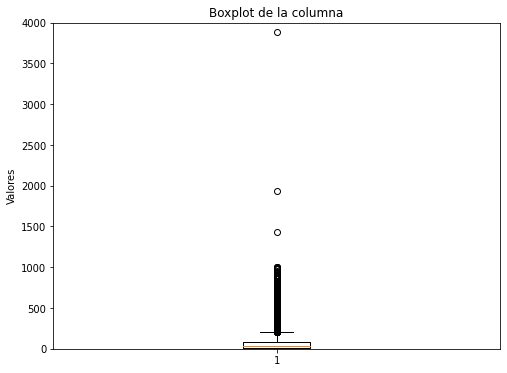

In [38]:
# Crear un boxplot de una sola columna del dataframe
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(data['c55'])

# Personalizar el gráfico
ax.set_title('Boxplot de la columna')
ax.set_ylabel('Valores')
plt.ylim(0, 4000)
# Mostrar el gráfico
plt.show()

Efectivamente es muy posible, contaremos ahora la cantidad de filas en las que se repiten estos valores para poder ver si es algo frecuente o es algo puntual que tiene bastante probabilidad de ser valor erroneo

In [39]:
# Supongamos que la columna se llama 'nombre_columna' y está en el dataframe 'df'
conteo = data['c55'].between(1200, 4000, inclusive=True).sum()

print(f"El número de filas con valor entre 2000 y 4000 es: {conteo} de {len(data)} filas totales del dataframe")

El número de filas con valor entre 2000 y 4000 es: 3 de 214855 filas totales del dataframe


C:\Users\Neuraprint\AppData\Local\Temp\ipykernel_3036\3049402055.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  conteo = data['c55'].between(1200, 4000, inclusive=True).sum()


Procederemos a eliminar esos tres registros  que tomaremos como erroneos

In [40]:
columna = data['c55']
mascara = columna.between(1200, 4000, inclusive=True)
#mascara.count() 
data = data[~mascara].dropna()

conteo = data['c55'].between(1200, 4000, inclusive=True).sum()
print(f"El número de filas con valor entre 2000 y 4000 es: {conteo} de {len(data)} filas totales del dataframe")

El número de filas con valor entre 2000 y 4000 es: 0 de 214852 filas totales del dataframe


C:\Users\Neuraprint\AppData\Local\Temp\ipykernel_3036\2277819193.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  mascara = columna.between(1200, 4000, inclusive=True)
C:\Users\Neuraprint\AppData\Local\Temp\ipykernel_3036\2277819193.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  conteo = data['c55'].between(1200, 4000, inclusive=True).sum()


Tras el tratamiento a la posibilidad de valores erraticos debido a la desviación que presenta la columna c55 observamos que los datos son aparentemente correctos y es la naturaleza de los mismos la que produce esa desviación.C6 aparenta tener el mismo problema pero es también debido a que es una fecha.

In [41]:
data.skew()

c1             0.008434
c6             0.494733
c7            -0.250016
c8             0.031885
c10           -0.191045
c23            0.637672
c24            0.284687
c11           -0.071224
c110           1.182237
c61            8.017668
c62            8.127091
c65            3.544607
c68            3.712896
c41            0.915407
c45            0.096061
c49           -0.037389
c50            0.565783
c52           -0.908125
c53           10.068966
c54            2.226637
c55          389.202722
c56            2.838738
c130           0.254628
c96            0.587541
c48           -3.158284
c51           -1.233546
accidente      5.246623
dtype: float64

# Retirar una fila que nos servirá para ver qué precisión tendrá el modelo

Es posible que exista un método de separación más preciso pero por el momento utilizaremos una fila aleatoria cuyo valor sea 0 como accidente generando un nuevo dataframe df_neg y el mismo proceso para generar un dataframe df_pos donde tenga valor 1 como accidente

In [42]:
# seleccionar las filas que tienen un valor de 1 en la columna "accidente"
data_accidente_1 = data.loc[data['accidente'] == 1].head(5)

# seleccionar las filas que tienen un valor de 0 en la columna "accidente"
data_accidente_0 = data.loc[data['accidente'] == 0].head(5)

# concatenar los dos DataFrames
data_1 = pd.concat([data_accidente_1, data_accidente_0])

# eliminar las filas de data_1 de data para obtener data_2
data = data.drop(data_1.index)

# Escalar los datos

In [43]:
from sklearn.preprocessing import StandardScaler

cat_cols=['c1', 'c6', 'c7', 'c8', 'c11', 'c110', 'c65', 'c68', 'c41', 'c45', 'c49', 'c50', 'c52', 'c130', 'c96', 'c48', 'c51','c23','c24','accidente']
num_cols= ['c10', 'c61', 'c62', 'c53', 'c54', 'c55', 'c56']

df = pd.DataFrame(data)
print(df.dtypes)
# Seleccionamos los atributos numéricos y los estandarizamos
#num_cols = df.select_dtypes(include=['int', 'float']).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Creamos un nuevo dataframe con los datos categóricos y los datos numéricos estandarizados
#cat_cols = df.select_dtypes(include=['object']).columns
df = pd.concat([df[cat_cols], df[num_cols]], axis=1)

print(df)

c1             int32
c6             int32
c7             int32
c8             int32
c10          float64
c23            int32
c24            int32
c11            int32
c110           int32
c61          float64
c62          float64
c65            int32
c68            int32
c41            int32
c45            int32
c49            int32
c50            int32
c52            int32
c53          float64
c54          float64
c55          float64
c56          float64
c130           int32
c96            int32
c48            int32
c51            int32
accidente      int64
dtype: object
        c1  c6  c7  c8  c11  c110  c65  c68  c41  c45  ...   c23   c24  \
5        0   1   0   0   15     3    0    0    3   34  ...   809   538   
6        0   1   0   0   15     0    0    0    1    1  ...  2708  6550   
7        0   1   0   0   10     0    0    0    1    1  ...   809   423   
8        0   1   0   0    7     1    0    0    1    1  ...  1568  2115   
9        0   1   0   0   14     0    0    0    5 

Una vez ya realizado el tratamiento de los datos guardamos en un .parquet para proseguir con la predicción

In [44]:
repeated_values = df['accidente'].value_counts()
repeated_values_df = repeated_values.to_frame()
repeated_values_df.columns = ['Frequency']
print(repeated_values_df)

   Frequency
0     207801
1       7041


In [45]:
df.to_parquet("data_tratamiento_escalado.parquet")

In [46]:
df

,c1,c6,c7,c8,c11,c110,c65,c68,c41,c45,...,c23,c24,accidente,c10,c61,c62,c53,c54,c55,c56
5,0,1,0,0,15,3,0,0,3,34,...,809,538,0,0.312374,-0.202697,-0.173265,-0.446394,-0.891526,0.113684,-0.304466
6,0,1,0,0,15,0,0,0,1,1,...,2708,6550,0,-0.053199,-0.125506,-0.092720,-0.427915,-0.644015,-0.196961,-0.675207
7,0,1,0,0,10,0,0,0,1,1,...,809,423,0,0.092737,-0.241293,-0.213537,-0.250651,0.080841,-0.026325,-0.639494
8,0,1,0,0,7,1,0,0,1,1,...,1568,2115,0,0.122510,-0.164101,-0.132993,-0.423124,-0.237388,-0.070078,-0.672642
9,0,1,0,0,14,0,0,0,5,34,...,1127,3651,0,0.148379,-0.241293,-0.213537,0.123039,-0.148991,-0.083204,0.360657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214882,1,48,4,27,9,5,1,0,1,55,...,2708,6460,0,-1.113802,-0.164101,-0.173265,-0.223959,0.190454,-0.249465,-0.612463
214883,1,48,4,27,3,5,1,0,1,55,...,94,3289,0,0.789719,-0.202697,-0.213537,0.192713,-0.640479,-0.203087,-0.681718
214884,1,48,0,24,9,5,4,0,3,55,...,2708,6486,0,-1.352962,-0.164101,-0.213537,-0.247914,0.823377,0.135560,-0.393452
214885,1,48,0,28,18,5,4,0,12,55,...,1279,7536,0,-2.390137,-0.164101,-0.213537,3.827094,1.604807,0.485583,2.100315


# Balancear el dataframe porque hay menos valores de accidente que de no accidentes en la variable objetivo accidente

### El dataset está muy desbalanceado por lo que hay que recurrir a balancearlo, primero se debe dividir en train_test y después balancear para que x_test e y_test  no contengan datos de train ya que al balancearlo con sobremuestreo duplica algunos registros y hay posibilidades de que se incluyan en x_test e y_test

### Otra opción frente al desbalanceos sería utilizar algoritmos que permitan controlar este desbalanceo mediante hiperparametros

In [47]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Cargar los datos en un dataframe
df = pd.read_parquet('data_tratamiento_escalado.parquet', engine='pyarrow')

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df.drop('accidente', axis=1) # todas las columnas excepto la etiqueta
y = df['accidente']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
#################################################################################################################
#####comentar las dos lineas de abajo si se está utilizando algoritmo de prediccion con opción activa de balanceo automatico########
#################################################################################################################
#oversampler = RandomOverSampler(random_state=42)
#X_train, y_train = oversampler.fit_resample(X_train, y_train)
#################################################################################################################

Balanceado y después dividido

In [48]:
X_train

,c1,c6,c7,c8,c11,c110,c65,c68,c41,c45,...,c51,c23,c24,c10,c61,c62,c53,c54,c55,c56
150111,1,26,6,5,7,0,13,30,1,1,...,15,2417,5717,-1.150408,-0.241293,-0.213537,-0.393010,0.328353,-0.148833,-0.574185
53830,1,8,2,3,8,0,0,17,5,34,...,11,1127,3692,-1.540874,0.646409,0.591907,-0.447078,-0.909206,-0.271341,-0.569253
23093,1,5,4,0,7,0,0,0,1,1,...,15,2708,6596,-0.198648,-0.241293,-0.213537,-0.364949,-0.909206,-0.271341,-0.652122
184146,1,36,0,30,18,5,1,0,5,55,...,16,809,781,0.621331,-0.164101,-0.173265,-0.207533,0.833984,0.056805,1.865519
28190,0,5,10,8,1,0,0,0,1,1,...,8,3350,4216,-0.833155,-0.202697,-0.173265,-0.002209,-0.025235,-0.052577,-0.107554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119889,1,19,11,18,4,0,1,0,3,34,...,15,485,1071,-0.894165,-0.164101,-0.173265,-0.385481,-0.202029,-0.096330,0.269501
103704,1,16,2,26,15,0,1,0,14,0,...,15,809,385,0.562761,-0.202697,-0.213537,-0.434075,-0.573297,-0.188211,-0.692767
131942,0,22,10,16,8,0,1,0,1,25,...,15,3333,8395,0.155212,-0.202697,-0.213537,-0.433390,-0.555618,-0.140083,-0.661790
146877,1,24,6,17,7,0,4,17,5,34,...,11,1127,3698,-0.340192,0.993771,0.873812,-0.447078,-0.456613,-0.159334,2.220673


In [49]:
X_test

,c1,c6,c7,c8,c11,c110,c65,c68,c41,c45,...,c51,c23,c24,c10,c61,c62,c53,c54,c55,c56
200577,1,41,2,21,3,5,1,0,15,55,...,16,485,2063,0.172295,-0.164101,-0.173265,-0.424356,0.010124,-0.000074,0.044491
64320,0,10,9,9,3,0,0,0,1,1,...,9,150,7855,1.497438,-0.241293,-0.213537,-0.447078,-0.909206,-0.271341,-0.589575
56263,0,9,7,14,18,0,0,0,12,54,...,11,1565,747,0.777517,-0.241293,-0.213537,-0.446394,-0.891526,0.345574,5.088534
22917,1,5,0,3,14,0,0,0,3,34,...,15,809,937,0.521274,-0.086910,-0.052448,-0.104871,-0.909206,-0.271341,0.977637
7082,0,2,11,29,7,0,0,0,1,1,...,3,282,5330,-0.136661,-0.241293,-0.213537,-0.447078,-0.909206,-0.271341,-0.679548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116547,1,19,5,1,18,0,1,0,1,1,...,15,485,3963,0.350445,-0.202697,-0.213537,0.921752,1.222932,0.894234,0.089754
148344,0,25,10,4,1,0,1,0,1,1,...,15,2708,6511,0.777517,-0.164101,-0.173265,0.148363,0.851664,-0.205712,-0.576159
194244,1,39,6,9,14,5,1,0,1,55,...,16,809,8429,-0.698932,-0.202697,-0.213537,-0.390272,0.229348,-0.214463,-0.521899
203694,0,43,8,0,18,5,1,0,1,55,...,16,809,471,-0.564709,-0.202697,-0.213537,0.305778,0.742052,0.437455,-0.482438


In [50]:
y_train

150111    0
53830     0
23093     0
184146    0
28190     0
         ..
119889    0
103704    0
131942    0
146877    0
121968    0
Name: accidente, Length: 128905, dtype: int64

In [51]:
y_test

200577    0
64320     0
56263     0
22917     0
7082      0
         ..
116547    0
148344    0
194244    0
203694    0
81032     0
Name: accidente, Length: 85937, dtype: int64

In [52]:
repeated_values = y_test.value_counts()
repeated_values_df = repeated_values.to_frame()
repeated_values_df.columns = ['Frequency']
print(repeated_values_df)

   Frequency
0      83071
1       2866


In [53]:
repeated_values = y_train.value_counts()
repeated_values_df = repeated_values.to_frame()
repeated_values_df.columns = ['Frequency']
print(repeated_values_df)

   Frequency
0     124730
1       4175


# Predecir

Predicción ejecutada en keras por problemas de ejecución en equipo local

https://www.kaggle.com/josepy/prediccion-final/edit

# RandomForest 

# SVM

# XGB

In [54]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Entrenar el modelo XGBoost
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False,
    tree_method="hist",
    max_depth=6,
    learning_rate=0.01,
    n_estimators=500,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=3,
    reg_lambda=0.1,
    gamma=0.1,
)
xgb_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Precisión del modelo: {:.2f}%".format(accuracy * 100))
print("Precisión equilibrada del modelo: {:.2f}%".format(balanced_accuracy * 100))
print("Área bajo la curva ROC: {:.2f}%".format(auc_roc * 100))
print("Matriz de confusión:\n", cm)

c:\users\neuraprint\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Precisión del modelo: 89.55%
Precisión equilibrada del modelo: 93.01%
Área bajo la curva ROC: 93.01%
Matriz de confusión:
 [[74185  8886]
 [   94  2772]]


In [55]:
import pickle


# Guardar el modelo en un archivo
with open('modelo_entrenado.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Exportación del modelo de predicción

# Carga del modelo

In [56]:
import pickle

# Cargar el modelo guardado en un archivo
with open('modelo_entrenado.pkl', 'rb') as f:
    xgb = pickle.load(f)

# Utilizar el modelo cargado para hacer predicciones
y_pred = xgb.predict(X_test)

Usar el modelo cargado para hacer predicciones sobre nuevos datos. Asegúrate de que los nuevos datos estén en el mismo formato que los datos utilizados para entrenar el modelo.

En este ejemplo, los nuevos datos son una lista de tres vectores de características, cada uno con tres características. Utilizamos el método predict() del modelo cargado para hacer predicciones sobre estos nuevos datos. Las predicciones se almacenan en la variable predicciones.

Es importante tener en cuenta que los nuevos datos deben estar en el mismo formato que los datos utilizados para entrenar el modelo, es decir, deben tener el mismo número de características y estar en el mismo orden. Además, asegúrate de que cualquier preprocesamiento que hayas realizado en los datos de entrenamiento también se aplique a los nuevos datos antes de hacer predicciones con el modelo.


# Verificación con dataset que apartamos para realizar una segunda comprobación con datos que no ha utilizado el algoritmo para test

In [57]:
### Verificación con dataset que apartamos para realizar una segunda comprobación

Capturamos la estructura de los datos de train para adaptar los datos de entrada nuevos a dicha estructura(orden y numero de columnas) para poder realizar la predicción

In [59]:
#la variable orden es para que queden en el mismo orden las columnas del dataset para que puedan ser aceptadas para la prediccion
orden=X_test.columns
# seleccionar datos del dataframe que ya separamos
#entrada_datos=df_nuevo.iloc[0:1,:-1]
print(data_1)
#new_data = data_1[0:1]
new_data = data_1.loc[:, orden]

# Mostrar nuevo DataFrame
print(new_data)

#Realizar la predicción
predicciones = xgb.predict(new_data)
print("las predicciones obtenidas son",predicciones)

for i in predicciones:
    
    if i == 0:
        print("No hay riesgo de accidentes con los datos aportados",i)
    
    else: 
        print("Hay riesgo de accidente elevado con la información aportada",i)
    
    


    c1  c6  c7  c8     c10   c23   c24  c11  c110   c61  ...  c52     c53  \
17   0   1   0  11  1028.4   485  2081   17     0   4.0  ...    4     0.0   
46   0   1   0  26  1150.8   809   465    3     1   2.0  ...   12     0.0   
53   0   1   0  26  1257.6   809  8734   10     0   3.0  ...    9    51.0   
68   0   1   0  29  1217.8  2708  6566    7     1   3.0  ...   12   100.0   
78   0   1   0  30  1699.0  1075  3835   17     0  10.0  ...    9  2774.0   
0    0   1   0   0  1474.0  1568  2111    3     3   1.0  ...    9   101.0   
1    0   1   0   0  1408.0   809   486    7     0   0.0  ...    1   124.0   
2    0   1   0   0  1586.0   809   375   14     2   0.0  ...   12   202.0   
3    0   1   0   0  1575.0   809   440    7     0   1.0  ...   14    77.0   
4    0   1   0   0  1440.2   809   465   10     0   2.0  ...   12     1.0   

      c54    c55     c56  c130  c96  c48  c51  accidente  
17    0.0    0.0  2400.0    10   45   11    1          1  
46    0.0    0.0  2001.4    10   1